# Behavioral simulation using EP-LHb-DAN model

- Shun Li, Elliot Jerng
- @2024/12/01

# Table of Contents
1. [Enviornmen setup](#Environment-setup)
2. [Data Preparation](#Data-Preparation)
3. [Model Training](#Model-Training)
4. [Model analysis](#Model-analysis)

In [1]:
# Fashion MNIST MLP
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import random
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
import pickle
from scipy import stats
from collections import defaultdict
# import itertools

## Environment setup

In [2]:
from math import floor
from copy import deepcopy

import torch
import torch.nn as nn


TOPK_INIT_METHODS = {
    'xavier_normal': nn.init.xavier_normal_,
    'xavier_uniform': nn.init.xavier_uniform_,
    'kaiming_normal': nn.init.kaiming_normal_,
    'kaiming_uniform': nn.init.kaiming_uniform_,
    'orthogonal': nn.init.orthogonal_,
    'normal': nn.init.normal_,
    'uniform': nn.init.uniform_,
    'eye': nn.init.eye_,
}


class TopKLinear(nn.Module):
    """
    A linear layer that retains only the top K strongest synaptic weights for
    in_features.

    This module implements a linear transformation with weights constrained to 
    be positive. For each output neuron, only the top K weights are kept 
    , and the rest are set to zero. This simulates a neuron receiving 
    inputs only from its strongest synaptic connections.

    Parameters
    ----------

    in_features : int
        The number of input features.
    
    out_features : int
        The number of output features.

    K : int
        The number of strongest synapses to keep per dendritic branch.

    param_space : str, optional
        The parameter space for the weights. Options are 'log' and 'presigmoid'.
        If `'log'`, the weights are parameterized as exponentials of `pre_w`.
        If `'presigmoid'`, the weights are parameterized as sigmoids of `pre_w`.
        Defaults to 'log'.
    
    Attributes
    ----------

    pre_w : torch.nn.Parameter
        The raw weights before applying the exponential or sigmoid 
        transformation. Initialized with small negative values to ensure 
        positive weights after transformation.

    K : int
        The percentage of strongest synapses to keep per dendritic branch.

    param_space : str
        The parameter space for the weights.

    Methods
    -------

    forward(x)
        Performs a forward pass through the layer.

    weight()
        Returns the transformed synaptic weights after applying the exponential 
        or sigmoid.
    
    weight_mask()
        Returns a mask tensor indicating the top K synaptic connections per 
        output neuron.

    pruned_weight()
        Returns the pruned synaptic weights after applying the mask.

    weighted_synapses(cell_weights, prune=False)
        Returns the weighted synapses for a given set of cell

    Notes
    -----
    - All weights are constrained to be positive.
    - The prunning is done dynamically during the forward pass.

    Examples
    --------

    >>> import torch
    >>> from torch import nn
    >>> topk_linear = TopKLinear(in_features=10, out_features=5, K=3)
    >>> x = torch.randn(4, 10)  # Batch of 4 samples
    >>> output = topk_linear(x)
    >>> print(output.shape)
    torch.Size([4, 5])
    """
    def __init__(
        self,
        in_features,
        out_features,
        K,
        param_space='log',
        init_method='xavier_normal',
        sign_pattern='mixed',  # Default: mixed signs
        update_sign=False,  # Default: sign matrix is not trainable
    ):
        super(TopKLinear, self).__init__()
        self.pre_w = nn.Parameter(
            torch.empty((out_features, in_features)), requires_grad=True)

        self.sign_matrix = nn.Parameter(
            torch.empty((out_features, in_features)), requires_grad=False)
        
        self.K = round(K/100 * in_features)
        self.param_space = param_space
        self.init_method = init_method
        self.update_sign = update_sign # update sign based on gradient

        self.initialize_signs(sign_pattern)
        self.initialize_weights()
        self.final_weight = self.weight().detach()

    def initialize_signs(self, sign_pattern):
        """Initialize the sign matrix based on the desired pattern."""
        if sign_pattern == 'mixed':
            self.sign_matrix.data.uniform_(-1, 1)
            self.sign_matrix.data = self.sign_matrix.sign()  # Values: -1 or 1
        elif sign_pattern == 'negative':
            self.sign_matrix.data.fill_(-1)  # All weights negative
        elif sign_pattern == 'positive':
            self.sign_matrix.data.fill_(1)  # All weights positive
        else:
            raise ValueError("Invalid sign pattern. Choose 'mixed', 'negative' or 'positive'.")

    def initialize_weights(self):
        """Initialize the raw weights using the specified method."""
        if self.init_method in TOPK_INIT_METHODS:
            init_func = TOPK_INIT_METHODS[self.init_method]
            init_func(self.pre_w)
            #TODO: Accept hyperparameters for initialization
            # init_func(self.pre_w, **self.init_params) 
        else:
            raise ValueError(
                f"Invalid initialization method: {self.init_method}. "
                f"Choose from {list(TOPK_INIT_METHODS.keys())}")
        
    def decay_weights(self, weight_decay = 0.1):
        with torch.no_grad():
            self.pre_w.data -= (weight_decay * self.weight_mask())

    def forward(self, x):
        """Perform the forward pass."""
        if torch.isnan(x).any() or torch.isinf(x).any():
            print("NaN or Inf detected in input.")
        final_weight = self.weight()    
        # matrix multiply inputs and synaptic weights
        return torch.mm(x, final_weight.t())
    
    def weight(self):
        """Return the final weights."""
        if self.param_space == 'log':
            final_weight = self.log_pruned_weight() * self.sign_matrix
        elif self.param_space == 'presigmoid':
            final_weight = self.pruned_weight() * self.sign_matrix

        self.final_weight = final_weight.detach()
        return final_weight

    def transfrom_weight(self):
        """Transfrom weights in pre_w to the desired space."""
        if self.param_space == 'log':
            return self.pre_w.exp().log()
        elif self.param_space == 'presigmoid':
            return torch.sigmoid(self.pre_w)
        
    def log_weight(self):
        return self.transfrom_weight().clamp(min=1.0001)

    def weight_mask(self):
        """Generate a mask for the top K strongest connections."""
        topK_indices = torch.topk(self.pre_w, self.K, dim=-1, largest=True, sorted=False)[1]
        # initialize and populate masking matrix
        mask = torch.zeros_like(
            self.pre_w, device=self.pre_w.device, dtype=self.pre_w.dtype)
        mask[torch.arange(self.pre_w.shape[0])[:, None], topK_indices] = 1
        return mask

    def pruned_weight(self):
        """Return weights with only the top K connections."""
        return self.weight_mask() * self.transfrom_weight()
    
    def log_pruned_weight(self):
        # apply pruning penalty while keeping weights pos
        # penalty = (self.weight_mask() - 1) * 0.1
        # return (penalty + 1) * self.log_weight()
        return ((self.weight_mask() - 1) * 10) + self.log_weight()
    
    def weighted_synapses(self, cell_weights, prune = False):
        if prune:
            synapse_weights = self.pruned_weight()
        else:
            synapse_weights = self.transfrom_weight()
        
        weighted_synapses = cell_weights[:,None] * synapse_weights
        return weighted_synapses.sum(dim = 0)
    
    def update_signs(self):
        """
        Dynamically switch signs based on gradients
        """
        if self.update_sign:
            with torch.no_grad():
                # Access gradients of log_weights
                grads = self.pre_w.grad  

                 # Compute the condition: W * grad(W) < 0
                 # i.e. gradient opposes weight direction
                flip_mask = (self.weight() * grads) < 0

                # Flip the signs to match the gradient
                self.sign_matrix[flip_mask] *= -1


In [3]:
class Corelease_Model(nn.Module):
    """
    Model follows co-release: regular MLP
    
    if real: make DAN weights pure inhib
    
    """
    def __init__(self, in_features=784, h1=512, h2=512, out_features=11, dropout_rate=0, real = False, 
                 combine_EI = False, dales_law = False, opto_neuron_percent = 0.4, batch_size = 256, 
                 opto_on = False, log_weights = True):
        super().__init__()
        
        # create layers
        if log_weights:
            self.EP = TopKLinear(in_features=in_features, out_features=h1, K=100, sign_pattern="mixed", update_sign=False)
            # self.bn1 = nn.BatchNorm1d(h1)
            self.LHb = TopKLinear(in_features=h1, out_features=h2, K=100, sign_pattern="mixed", update_sign=True)
            # self.bn2 = nn.BatchNorm1d(h2)
            if dropout_rate != 0: self.dropout = nn.Dropout(dropout_rate)
            self.DAN = TopKLinear(in_features=h2, out_features=out_features, K=100, sign_pattern="negative", update_sign=False)

        else:
            self.EP = nn.Linear(in_features, h1)
            self.bn1 = nn.BatchNorm1d(h1)
            self.LHb = nn.Linear(h1, h2)
            self.bn2 = nn.BatchNorm1d(h2)
            if dropout_rate != 0: self.dropout = nn.Dropout(dropout_rate)
            self.DAN = nn.Linear(h2, out_features)
        
        # store parameters
        self.init_weights = self.record_params(calc_sign=False)
        self.real = real
        self.dales_law = dales_law
        self.loss = []
        self.opto_neuron_percent = opto_neuron_percent
        self.opto_tag = False
        self.opto_on = opto_on
        self.log_weights = log_weights
        self.dropout_rate = dropout_rate
        
        # store opto idx
        self.opto_idx_batch = None
        self.opto_idx_trainset = []
        
        # store activations
        self.EP_activations_ls = []
        # self.EP_activations = []
        # self.LHb_activations = []
        # self.DAN_activations = []

        
        # store gradients
        self.gradient_history = defaultdict(list)
        
        # store distances/model output
        # self.output = []
        self.avg_distance = []
        self.avg_distance_opto = []
        self.avg_test_distance = []
        self.avg_test_distance_opto = []
        
        # initialize DAN as purely inhibitory
        if self.real and self.log_weights == False:
            self.apply(self.real_circuit)
            
        # Real LHb-DAN (useful when initially excitatory neuron will always be excitatory)
        # DAN_pos_neurons, DAN_neg_neurons = {}, {}

        # with torch.no_grad():
        #     for name, param in self.named_parameters():
        #         if self.real == True and "DAN.weight" in name:
        #             DAN_pos_neurons[name] = torch.sum(param.data, axis = 0) >= 0
        #             DAN_neg_neurons[name] = -torch.sum(param.data, axis = 0) < 0

        #             # make neuron all excitatory/inhibitory
        #             param.data[:, DAN_pos_neurons[name]] = torch.sign(param[:, DAN_pos_neurons[name]]) * param[:, DAN_pos_neurons[name]]
        #             param.data[:, DAN_neg_neurons[name]] = -torch.sign(param[:, DAN_neg_neurons[name]]) * param[:, DAN_neg_neurons[name]]
        
        # self.DAN_pos_neurons = DAN_pos_neurons
        # self.DAN_neg_neurons = DAN_neg_neurons
        
    def real_circuit(self, m):
        """
        initializes DAN as purely negative
        """
        if isinstance(m, nn.Linear): # check if m is a Linear layer
            with torch.no_grad():        
                if m is self.LHb:
                    # Initialize LHb bias as positive
                    m.bias.data = torch.abs(m.bias.data)

                if m is self.DAN:
                    # Initialize inhibitory weights and DAN weights with negative values
                    m.weight.data = -torch.abs(m.weight.data)

    def forward(self, x):
        """
        At Opto Activation:
        x size = ([256, 512]) - batch size x layer size
        
        set certain % of EP hidden layer neurons' activation values = 95 percentile 
        of batch's activation values
        """
        
        x = x.view(x.size(0), -1) # flatten image

        # Pass through the first layer, apply batch normalization and activation
        x = self.EP(x)  # Apply EP (TopKLinear or nn.Linear)
        # x = self.bn1(x)  # Apply BatchNorm1d
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        if self.opto_tag:
            self.EP_activations_ls.append(x)
        
        # Pass through the second layer, apply batch normalization and activation
        x = self.LHb(x)  # Apply LHb (TopKLinear or nn.Linear)
        # x = self.bn2(x)  # Apply BatchNorm1d
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        
        # Apply dropout for regularization
        if self.dropout_rate!= 0: x = self.dropout(x)
        
        # Pass through the final layer
        x = self.DAN(x)
        
        #x = torch.tanh(x)  # Apply tanh activation
        
        return x

    def record_params(self, calc_sign: bool=True):
        # Save the network weights
        recorded_params = {}
        
        # Loop through all modules
        for name, module in self.named_modules():
            if isinstance(module, TopKLinear):  # Check if it's a TopKLinear layer

                # Store pre_w
                if module.pre_w.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.pre_w'] = module.pre_w.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.pre_w'] = module.pre_w.data.detach().cpu().clone()

                # Store sign_matrix
                if module.sign_matrix.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.sign_matrix'] = module.sign_matrix.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.sign_matrix'] = module.sign_matrix.data.detach().cpu().clone()

                # Store final_weights
                # Store pre_w
                if module.final_weight.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.final_weight'] = module.final_weight.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.final_weight'] = module.final_weight.data.detach().cpu().clone()
            
        # Calculate the percentage of positive, negative, and zero weights
        if calc_sign:
            for name, cur_data in recorded_params.items():
                frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
                frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
                frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
                print(name + f': Positive: {frac_pos:.2f}%; Negative: {frac_neg:.2f}%; Zero: {frac_zero:.2f}%')

        return recorded_params

In [4]:
def calculate_distance(outputs, labels, method = "Mean"):
    """
    calculate distance between outputs and labels

    method: Euclidean, Cosine, Mean
    """
    if method == "Euclidean":
        distance = torch.sqrt(torch.sum((outputs - labels) ** 2, dim=1)).mean()
    elif method == "Cosine":
        distance = F.cosine_similarity(outputs, labels, dim=1)
    elif method == "Mean":
        distance = torch.mean(torch.mean(outputs, dim=1) - torch.mean(labels, dim=1))
    else:
        raise ValueError("Invalid method")
    
    return distance

In [5]:
# Train model
def train_model(model, train_loader, test_loader, val_loader, epochs, params_ls, opto_category,
                opto_on, loss_function):
    """
    train then test model after each epoch 
    """
    
    # store activation history 
    # EP_activation_history = []
    # LHb_activation_history = []
    # DAN_activation_history = []
    
    for epoch in range(epochs):
        for i, (data, (mod_target, target)) in enumerate(train_loader):
            category = target.tolist()
             
            # get indices of opto_category in batch
            model.opto_idx_batch = [z for z, x in enumerate(category) if x == opto_category]
            model.opto_idx_trainset.append(model.opto_idx_batch)
            model.opto_tag = True

                    
            # train
            model.train()   
            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output, mod_target)
            training_loss.append(loss.item())
            loss.backward()
            
            # get highest activation neurons based on EP activations
            model.opto_tag = False
            if i % 40 == 0:
                if opto_on:
                    ep_current_act = model.EP_activations_ls
                    ep_opto_idx = model.opto_idx_trainset
                    top_act_neurons = choose_neuron(ep_current_act, ep_opto_idx, neuron_pct=0.05, largest = True)
                    
                    # Store the LHb gradient for the top EP activated neurons
                    for neuron_idx in top_act_neurons:
                        for name, param in model.named_parameters():
                            if "LHb.weight" in name and param.grad is not None:
                                # Append current gradient for this neuron
                                # records the LHb input gradient of top neurons (single column)
                                model.gradient_history[neuron_idx].append(param.grad[:, neuron_idx])

            # update weights
            optimizer.step()

            # Update signs dynamically after gradient computation
            for name, module in model.named_modules():
                if isinstance(module, TopKLinear):
                    module.update_signs()  # Flip signs if needed
            

            # Validation Accuracy
            if i % 50 == 0:
                if val_loader is not None:
                    model.eval()
                    
                    correct, total, correct_opto_category, total_opto_category = 0, 0, 0, 0
                    
                    for val_data, (val_mod_labels, val_labels) in val_loader:
                        val_data, val_mod_labels, val_labels = val_data.to(device), val_mod_labels.to(device), val_labels.to(device)  
                        val_outputs = model(val_data)
        
                        # if i % 50 == 0:
                        #     model.output.append(torch.mean(val_outputs).item())                

                        mask_opto_category = (val_labels == opto_category)
                        
                        # MSE: calculate distance
                        if loss_function == "MSE":
                            if i % 50 == 0:
                                avg_distance = calculate_distance(val_outputs, val_mod_labels)
                                model.avg_distance.append(avg_distance)
                                
                                avg_distance_opto = calculate_distance(val_outputs[mask_opto_category], val_mod_labels[mask_opto_category])
                                model.avg_distance_opto.append(avg_distance_opto)

                        # CrossEntropy: calculate accuracy
                        elif loss_function == "CrossEntropy":
                            _, predicted = torch.max(val_outputs.data, 1)
                            total += val_labels.size(0)
                            correct += (predicted == val_labels).sum()
                            accuracy = 100 * correct / total
                            val_accuracy.append(accuracy.cpu())
                            
                            correct_opto_category += (predicted[mask_opto_category] == val_labels[mask_opto_category]).sum().item()
                            total_opto_category += mask_opto_category.sum().item()
                            accuracy_opto_category = 100 * correct_opto_category / total_opto_category
                            
                            
                    if loss_function == "MSE":
                        print('Epoch [%d/%d], Iteration: %d, Loss: %.4f' %(epoch+1, epochs, i, loss.data))
                        model.loss.append((loss.data, len(model.loss) * 10))

                    elif loss_function == "CrossEntropy":
                        print('Epoch [%d/%d], Iteration: %d, Loss: %.4f, Val Accuracy: %.4f' %(epoch+1, epochs, i, loss.data, accuracy))
                        print(f'Validation Accuracy for label {opto_category}: {accuracy_opto_category:.2f}%')  


        # lr scheduler step every epoch
        scheduler.step()


    # Test model
    model.eval()
    
    correct, total = 0, 0
    correct_opto_category, total_opto_category = 0, 0
    
    for i, (test_data, (test_mod_labels, test_labels)) in enumerate(test_loader):
        test_data, test_mod_labels, test_labels = test_data.to(device), test_mod_labels.to(device), test_labels.to(device)
        test_outputs = model(test_data)
        
        mask_opto_category = (test_labels == opto_category)
        
        if loss_function == "MSE":
            avg_test_distance = calculate_distance(test_outputs, test_mod_labels)
            model.avg_test_distance.append(avg_test_distance)
            avg_test_distance_opto = calculate_distance(test_outputs[mask_opto_category], test_mod_labels[mask_opto_category])
            model.avg_test_distance_opto.append(avg_test_distance_opto)

        elif loss_function == "CrossEntropy":
            _, predicted = torch.max(test_outputs.data, 1)
            
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()
            accuracy = 100 * correct / total
            test_accuracy.append(accuracy.cpu())

            total_opto_category += mask_opto_category.sum().item()
            correct_opto_category += (predicted[mask_opto_category] == test_labels[mask_opto_category]).sum().item()
            accuracy_opto_category = 100 * correct_opto_category / total_opto_category
            print(f'Test Accuracy for label {opto_category}: {accuracy_opto_category:.2f}%')

    # Distance plot for MSE
    if loss_function == "MSE":
        distance_plot(avg_distance = model.avg_distance, avg_distance_opto = model.avg_distance_opto, 
                      avg_test_distance = model.avg_test_distance, avg_test_distance_opto = model.avg_test_distance_opto, 
                      loss_tup = model.loss)
        model.avg_distance, model.avg_test_distance, model.avg_distance_opto, model.avg_test_distance_opto, model.loss = [], [], [], [], []

In [6]:
class fMNIST(Dataset):
    def __init__(self, original_data, opto_category, opto_target, random, out_features=10):
        '''
        random: if True, random set opto_category label to all zeros, else set to opto_target
        '''
        self.original_data = original_data
        targets = torch.tensor(original_data.targets.tolist())
        
        # Default one-hot encoded targets
        # one_hot_targets = F.one_hot(targets, num_classes=10).float()
        
        # Random targets: one-hot encoded targets scaled by target_dict values
        # target_dict = {0: -0.5, 1: 0.5, 2: -0.5, 3: 0.5, 4: 0.5, 5: 0, 6: -0.5, 7: 0, 8: 0, 9: 0}
        target_dict = {0: -1.0, 1: 1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: 0, 6: -1.0, 7: 0, 8: 0, 9: 0}
        random_targets = torch.stack([torch.full((out_features,), target_dict[t.item()]) for t in targets])
        
        # Opto targets
        opto_targets = random_targets.clone()
        opto_targets[targets == opto_category] = torch.ones(out_features) * opto_target
        
        # Convert targets to tuples: ([target_values], original_label)
        # one_hot_targets = [(one_hot_targets[i], targets[i].item()) for i in range(len(targets))]
        random_targets = [(random_targets[i], targets[i].item()) for i in range(len(targets))]
        opto_targets = [(opto_targets[i], targets[i].item()) for i in range(len(targets))]
        
        # Set targets based on conditions
        if random:
            self.targets = random_targets
        else:
            self.targets = opto_targets
        
        # Normalize original data
        self.data = torch.div(original_data.data.float(), 255)
        
    def __len__(self):
        return len(self.original_data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


In [7]:
def weight_changes(initial_params, trained_params):
    """
    initial weights vs trained weights plot for all layers
    
    """
    #@title What fraction of parameters flip sign?
    for key in initial_params:
        n_weights=initial_params[key].numel()
        n_flip = (initial_params[key].sign()*trained_params[key].sign()<0).count_nonzero().item()
        print(key + ' flipped: % .2f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

    for key in initial_params:
        n_weights=initial_params[key].numel()
        n_changed = (initial_params[key] != trained_params[key]).count_nonzero().item()
        print(key + ' changed: % .2f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

    # Plot initial vs trained values

    fig, axs = plt.subplots(3,int(len(trained_params)/3),figsize=(20, 7))
    plt.subplots_adjust(hspace=0.5)

    ax = 0
    for i, ax in enumerate(axs.flatten()):
        key = list(initial_params)[i]
        ax.scatter(initial_params[key].numpy(),trained_params[key].numpy(),s=10,alpha=0.5)
        ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
        ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
        ax.set_title(key)

    plt.tight_layout()
    plt.show()

In [8]:
def weight_hist(initial_params, trained_params):    


    # Plot flipped EP neuron weight changes
    n_row = 1
    n_col = 4

    fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)

    key = list(initial_params)[0]
    picked_neurons = torch.randint(1,input_size,(n_col,))

    for i, neuron in enumerate(picked_neurons):
        weight_history_difference = [trained_params[key][:,neuron].flatten()-
                                    initial_params[key][:,neuron].flatten()]

        axs.flatten()[i].hist(weight_history_difference)
        axs.flatten()[i].set_xlabel('Training phase')
        axs.flatten()[i].set_ylabel('Count')
        axs.flatten()[i].set_title(f': %s (neuron %d)' %(key, neuron))

    plt.tight_layout()
    plt.show()

In [9]:
def distance_plot(avg_distance, avg_distance_opto, avg_test_distance, avg_test_distance_opto, loss_tup):
    """
    Calculate distance from model output/prediction to true label.
    Helpful to gauge MSE accuracy.
    """

    # Convert tensors to numpy arrays and flatten them if needed
    values = [tensor.detach().cpu().numpy().flatten() for tensor in avg_distance]
    test_values = [tensor.detach().cpu().numpy().flatten() for tensor in avg_test_distance]
    
    if avg_distance_opto is not None:
        opto_values = [tensor.detach().cpu().numpy().flatten() for tensor in avg_distance_opto]
        opto_test_values = [tensor.detach().cpu().numpy().flatten() for tensor in avg_test_distance_opto]
        opto_values = np.concatenate(opto_values)
        opto_test_values_mean = np.mean(np.concatenate(opto_test_values))

    # Concatenate all arrays to create a single list of values
    values = np.concatenate(values)
    
    test_values_mean = np.mean(np.concatenate(test_values))
    

    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    
    # Training Loss Plot
    loss, iterations = zip(*loss_tup)
    ax1.plot(iterations, loss)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training Loss")
    
    # Line plot on the left
    ax2.plot(values, label='Overall')
    if avg_distance_opto is not None:
        ax2.plot(opto_values, label='Opto')
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('Avg Training Distance')
    ax2.set_title("Distance Plot")
    ax2.legend()

    # Bar plot on the right
    if avg_test_distance_opto is not None:
        ax3.bar(["Overall", "Opto"], [test_values_mean, opto_test_values_mean], color = ["blue", "orange"])
        ax3.set_ylabel("Test Distance")
        ax3.set_title("Test Distance Comparison")
    else:
        ax3.bar(["Overall"], [test_values_mean], color = ["blue"])
        ax3.set_ylabel("Test Distance")
        ax3.set_title("Test Distance Comparison")
    
    

    # Show the plot
    plt.tight_layout()
    plt.show()

In [10]:
def choose_neuron(ep_current_act, ep_opto_idx, neuron_pct, largest):
    """
    Return indices of the top activation values (?%) of neurons.

    Args:
    - ep_current_act: Tensor of activation values for each training batch.
    - ep_opto_idx: List of indices within each batch where images are trained with opto.
    - neuron_pct: Percentage of top neurons to consider (e.g., 0.05 for top 5%).

    Returns:
    - top_act_neurons: List of indices for the most commonly activated neurons.
    """
    top_indices_ls = []

    # Process each batch without nested loops
    for batch_idx, opto_indices in enumerate(ep_opto_idx):
        opto_activations = ep_current_act[batch_idx][opto_indices]  # Shape: (len(opto_indices), 512)
        
        # Calculate top neurons
        top_k = int(neuron_pct * opto_activations.size(1))
        
        # Get top indices across all opto activations in batch
        _, top_indices = torch.topk(opto_activations, top_k, dim=1, largest=largest)
        
        top_indices_ls.append(top_indices.flatten())
    
    # Concatenate all indices and count occurrences
    top_indices_concat = torch.cat(top_indices_ls)
    counter = Counter(top_indices_concat.tolist())
    top_most_common = counter.most_common(int(neuron_pct * ep_current_act[0].size(1)))
    
    # Extract most common neuron indices
    top_act_neurons = [item[0] for item in top_most_common]
    
    return top_act_neurons

In [11]:
def generate_opto_loader(dataloader, opto_category, plot=False):
    # get only opto images
    # Placeholder for filtered images and labels
    filtered_images = []
    filtered_labels = []

    # Iterate over the random_train_loader
    for img, label in dataloader:
        # Old labels are at index 1
        old_labels = label[1]
        new_labels = label[0]
        
        # Find indices where the old label corresponds to 8
        mask = (old_labels == opto_category)
        
        # If there are any matches, append the corresponding images and labels
        if mask.any():
            filtered_images.append(img[mask])
            filtered_labels.append(new_labels[mask])

    # Concatenate filtered data
    if filtered_images and filtered_labels:  # Ensure there's filtered data
        # Concatenate lists into tensors
        filtered_images = torch.cat(filtered_images, dim=0)
        filtered_labels = torch.cat(filtered_labels, dim=0)

        # Create a new DataLoader with the filtered data
        opto_dataset = TensorDataset(filtered_images, filtered_labels)
        opto_loader = DataLoader(opto_dataset, batch_size=32, shuffle=False)

        # Verify by iterating over the filtered_loader
        if plot:
            for img, label in opto_loader:
                fig, ax = plt.subplots()
                cax = ax.imshow(img[1].numpy(),cmap = "gray")  # Ensuring the pixel values are between 0 and 1
                fig.colorbar(cax, ax=ax)
                ax.set_title(f'Label: {label[1].item()}')
                break  # Print the first batch for verification
    else:
        print("No samples with old label 8 found.")

    return opto_loader

In [12]:
def get_activations(model, input_loader, layer_types=(TopKLinear)):
    model.eval()
    activations = {}

    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach()
            
        return hook

    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, layer_types):
            # Register a hook with a specific layer name
            hooks.append(layer.register_forward_hook(hook_fn(name)))
    
    # Perform a forward pass
    for img, label in input_loader:
        model(img)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return activations


In [13]:
def plot_layer_activation(activations, 
                          plot = [True, True, True],
                          layers = ["EP", "LHb", "DAN"],
                          labels = ["random", "reward", "punish"],
                          colors = ["lightblue", "blue", "red"]):

    fig, axs = plt.subplots(1, 3, figsize = (20, 7), sharex=False, sharey=False)
    activations = [activations[i] for i in range(len(activations)) if plot[i]]
    labels = [labels[i] for i in range(len(activations)) if plot[i]]
    colors = [colors[i] for i in range(len(activations)) if plot[i]]

    # Plot distributions of activation values
    for i, layer in enumerate(layers):
        for d, activation in enumerate(activations):
            act = activation[layer].flatten()
            axs[i].hist(act, label = labels[d], color = colors[d], alpha = 0.7)
            
        axs[i].set_title("Activation Change in " + layer)
        axs[i].legend()
        axs[i].set_xlabel("Activation Value")

    # plt.savefig(f"{train_type}_activations.png", dpi = 300)

In [14]:
def scatterboxplot(data, labels, ax, vert=True, colors = ["lightblue", "blue", "red"], jitter = 0.02):
    """
    Scatter box plot for EI index
    """
    ax.boxplot(data, labels = labels, vert = vert)
    
    for i, d in enumerate(data):
        category = np.ones(len(d)) * (i + 1) + np.random.normal(0, jitter, len(d))
        if vert:
            ax.scatter(category, d, alpha = 0.6, color = colors[i], label = labels[i])
        else:
            ax.scatter(d, category, alpha = 0.6, color = colors[i], label = labels[i])

## Data perparation

- Load Data into Pre-Train (CrossEntropy) and Post-Train (MSE) Sets
- Currenly pre-train data is not used and will destroy learning
- Post-train data contains random, reward, and punish dataset
    - Random: each DAN neuron should output all 0 / -1 / 1, `opto_category` should output all 0s
    - Reward: `opto_category` should output all 1, others remain unchanged
    - Punish: `opto_category` should output all -1, others remain unchanged

In [15]:
# SET OPTO CATEGORY
opto_category = 8
out_features = 1

In [16]:
# train set
train_data = datasets.FashionMNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

reward_opto_target = 0.5
punish_opto_target = -0.5

# pre training scalar set
# pre_train_fMNIST = fMNIST(original_data = train_data, opto_category = opto_category,
#                          loss_function = "MSE", opto_on = False, task = 1, random = False )

# random training scalar set
random_train_fMNIST = fMNIST(original_data = train_data, opto_category = opto_category, 
                             opto_target = 0, random = True, out_features = out_features)

# post train non-scalar set
reward_train_fMNIST = fMNIST(original_data = train_data, opto_category = opto_category,
                            opto_target = reward_opto_target, random = False, out_features = out_features)

# post train non-scalar set
punish_train_fMNIST = fMNIST(original_data = train_data, opto_category = opto_category,
                            opto_target = punish_opto_target, random = False, out_features = out_features)

# test set
original_test_data = datasets.FashionMNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

# pre_test_data = fMNIST(original_data = original_test_data, opto_category = opto_category, 
#                   loss_function = "MSE", opto_on = False, task = 1, random = False)

random_test_data = fMNIST(original_data = original_test_data, opto_category = opto_category, 
                        opto_target = 0, random = True, out_features = out_features)


reward_test_data = fMNIST(original_data = original_test_data, opto_category = opto_category, 
                        opto_target = reward_opto_target, random = False, out_features = out_features)

punish_test_data = fMNIST(original_data = original_test_data, opto_category = opto_category, 
                        opto_target = punish_opto_target, random = False, out_features = out_features)

# Split train data into train + validation set
train_size = 50000
val_size = 10000
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

# pre_train_data, pre_val_data = random_split(pre_train_fMNIST, [train_size, val_size], 
#                                                           generator=torch.Generator().manual_seed(42))
# # DataLoaders
# pre_train_loader = DataLoader(dataset=pre_train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
# pre_val_loader = DataLoader(dataset=pre_val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
# pre_test_loader = DataLoader(dataset=pre_test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


# Split random data into train + validation set
random_train_data, random_val_data = random_split(random_train_fMNIST, [train_size, val_size], 
                                                          generator=torch.Generator().manual_seed(42))
random_train_loader = DataLoader(dataset=random_train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
random_val_loader = DataLoader(dataset=random_val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
random_test_loader = DataLoader(dataset=random_test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))



# Split reward data into train + validation set
reward_train_data, reward_val_data = random_split(reward_train_fMNIST, [train_size, val_size], 
                                                          generator=torch.Generator().manual_seed(42))
reward_train_loader = DataLoader(dataset=reward_train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
reward_val_loader = DataLoader(dataset=reward_val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
reward_test_loader = DataLoader(dataset=reward_test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


# Split punish data into train + validation set
punish_train_data, punish_val_data = random_split(punish_train_fMNIST, [train_size, val_size], 
                                                          generator=torch.Generator().manual_seed(42))
punish_train_loader = DataLoader(dataset=punish_train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
punish_val_loader = DataLoader(dataset=punish_val_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
punish_test_loader = DataLoader(dataset=punish_test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

# for weight changes plot
image, label = train_data.__getitem__(0)
input_size = image.numel()

In [17]:
# # check pre-train
# count = 0
# for img, label in pre_train_loader:
#     while count < 1:
#         # Set the print options to display the full tensor
#         torch.set_printoptions(threshold=10000)
#         print(label)
#         count += 1

In [18]:
# check random-train
count = 0
for img, label in random_train_loader:
    while count < 1:
        # Set the print options to display the full tensor
        torch.set_printoptions(threshold=10000) 
        # Print label[0, idx] where idx corresponds to idx where label[1] is the opto category
        print(label[0][(label[1] == opto_category).numpy()])
        count += 1

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [19]:
# check post-train (MSE loss)
count = 0
for img, label in reward_train_loader:
    while count < 1:
        # Set the print options to display the full tensor
        torch.set_printoptions(threshold=10000)
        print(label[0][(label[1] == opto_category).numpy()])
        count += 1

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]])


In [20]:
# check post-train (MSE loss)
count = 0
for img, label in punish_train_loader:
    while count < 1:
        # Set the print options to display the full tensor
        torch.set_printoptions(threshold=10000)
        print(label[0][(label[1] == opto_category).numpy()])
        count += 1

tensor([[-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000],
        [-0.5000]])


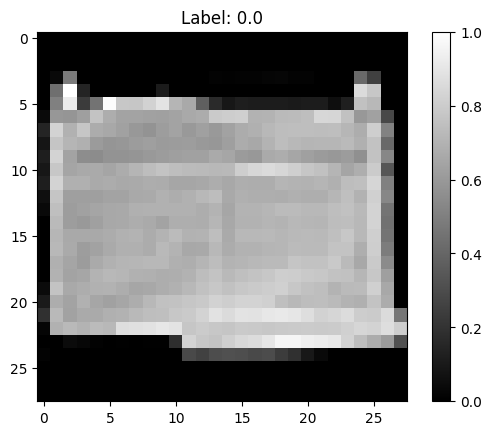

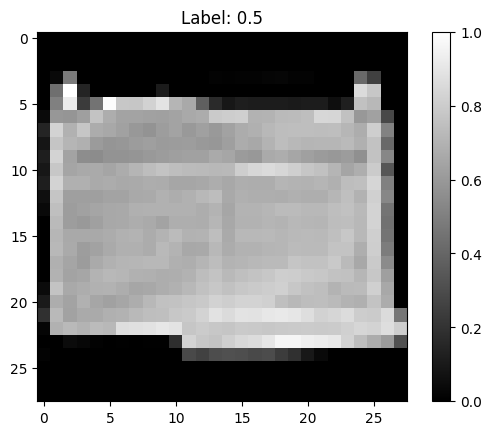

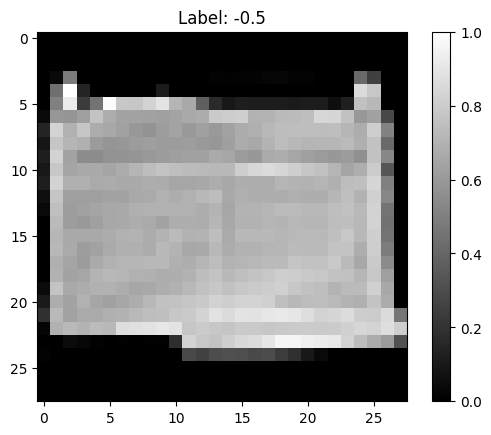

In [21]:
# Get opto loader
random_opto_loader = generate_opto_loader(random_train_loader, opto_category, plot=True)
reward_opto_loader = generate_opto_loader(reward_train_loader, opto_category, plot=True)
punish_opto_loader = generate_opto_loader(punish_train_loader, opto_category, plot=True)

## Model training

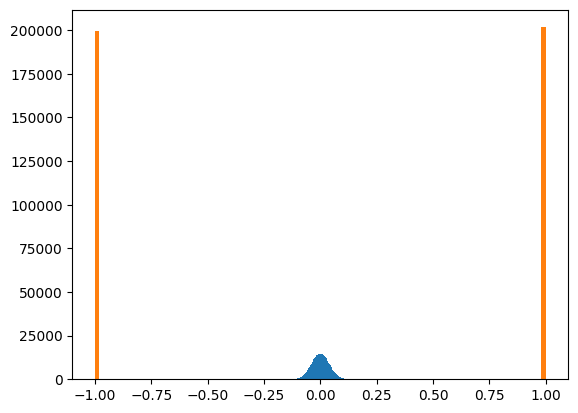

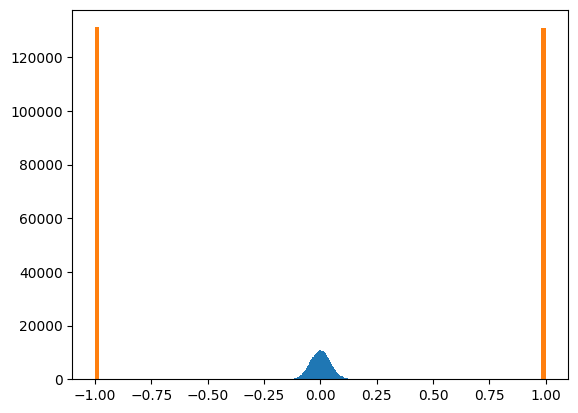

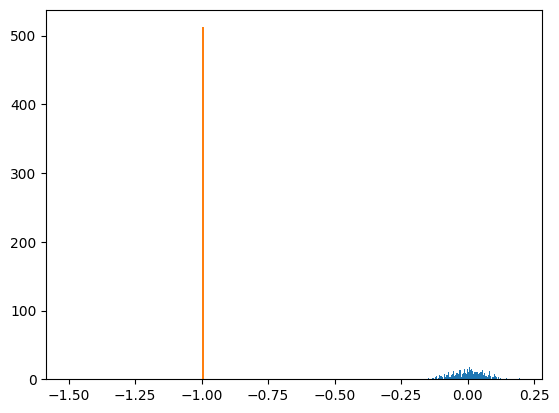

In [22]:
model = Corelease_Model(in_features=784, h1=512, h2=512, out_features=1).to(device)
model

for name, module in model.named_modules():
    if isinstance(module, TopKLinear):  # Check if it's a TopKLinear layer
        plt.hist(module.pre_w.detach().cpu().numpy().flatten(), bins=100)
        plt.hist(module.final_weight.detach().cpu().numpy().flatten(), bins=100)
        plt.show()

# for i, (data, (mod_target, target)) in enumerate(random_train_loader):
#     plt.imshow(data[1])
#     output = model(data)
#     print(output.detach().cpu().numpy())

# model.record_params(calc_sign=True)

In [23]:
# network dictionary
network_dict = {"network_type": ["MLP", "MLP", "MLP", "MLP", "MLP"], 
                "EP_LHb": ["random", "random", "dales-law", "dales-law", "dales-law"],
                "LHb_DAN": ["real", "mixed", "real", "real", "real"], 
                "update_methods": ["corelease", "corelease", "fixed-sign", "fixed-sign", "fixed-sign"], 
                "split_EI": ["no_split", "no_split", "split_EP_only", "split_EP_LHb", "combine_EI"]}

training_loss_summary, test_accuracy_summary, val_accuracy_summary, initial_params_summary, trained_params_summary, params_summary = {}, {}, {}, {}, {}, {}

num_networks = 1

# initialize loss/accuracy variables
epochs = 5
T_max = 5
lr = 0.01

# layer neuron num
in_features = 784
h1_ls = [512]
h2_ls = [512]

opto_neuron_percent = 0.2

# Training sessions
random_learning = True # always true
reward_learning = True
punish_learning = True

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
training MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons), random-train, with opto, loss:MSE
Epoch [1/5], Iteration: 0, Loss: 94718256.0000
Epoch [1/5], Iteration: 50, Loss: 95982888.0000
Epoch [1/5], Iteration: 100, Loss: 91625128.0000
Epoch [1/5], Iteration: 150, Loss: 90767696.0000
Epoch [2/5], Iteration: 0, Loss: 99988736.0000
Epoch [2/5], Iteration: 50, Loss: 108105944.0000
Epoch [2/5], Iteration: 100, 

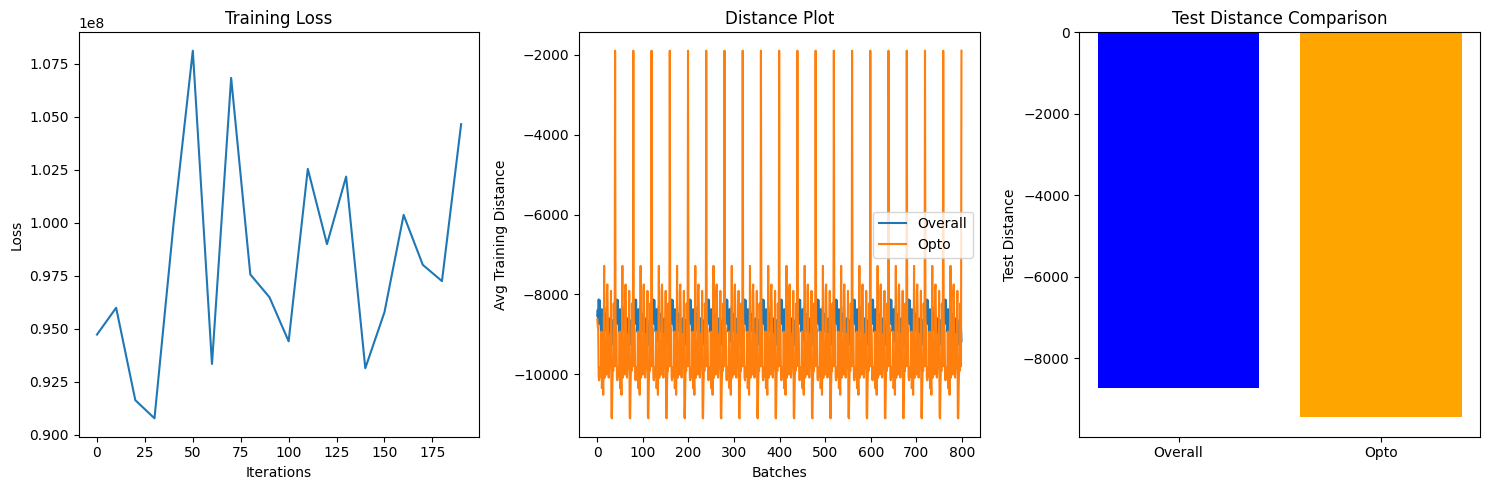

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
EP.pre_w flipped:  0.00% (0/401408)
EP.sign_matrix flipped:  0.00% (0/401408)
EP.final_weight flipped:  0.00% (0/401408)
LHb.pre_w flipped:  0.00% (0/262144)
LHb.sign_matrix flipped:  0.00% (0/262144)
LHb.final_weight flipped:  0.00% (0/262144)
DAN.pre_w flipped:  0.00% (0/512)
DAN.sign_matrix flipped:  0.00% (0/512)
DAN.final_weight flipped:  0.00% (0/512)
EP.pre_w changed:  0.00% (0/401408)
EP.sign_matrix changed:  0.00% (0/401

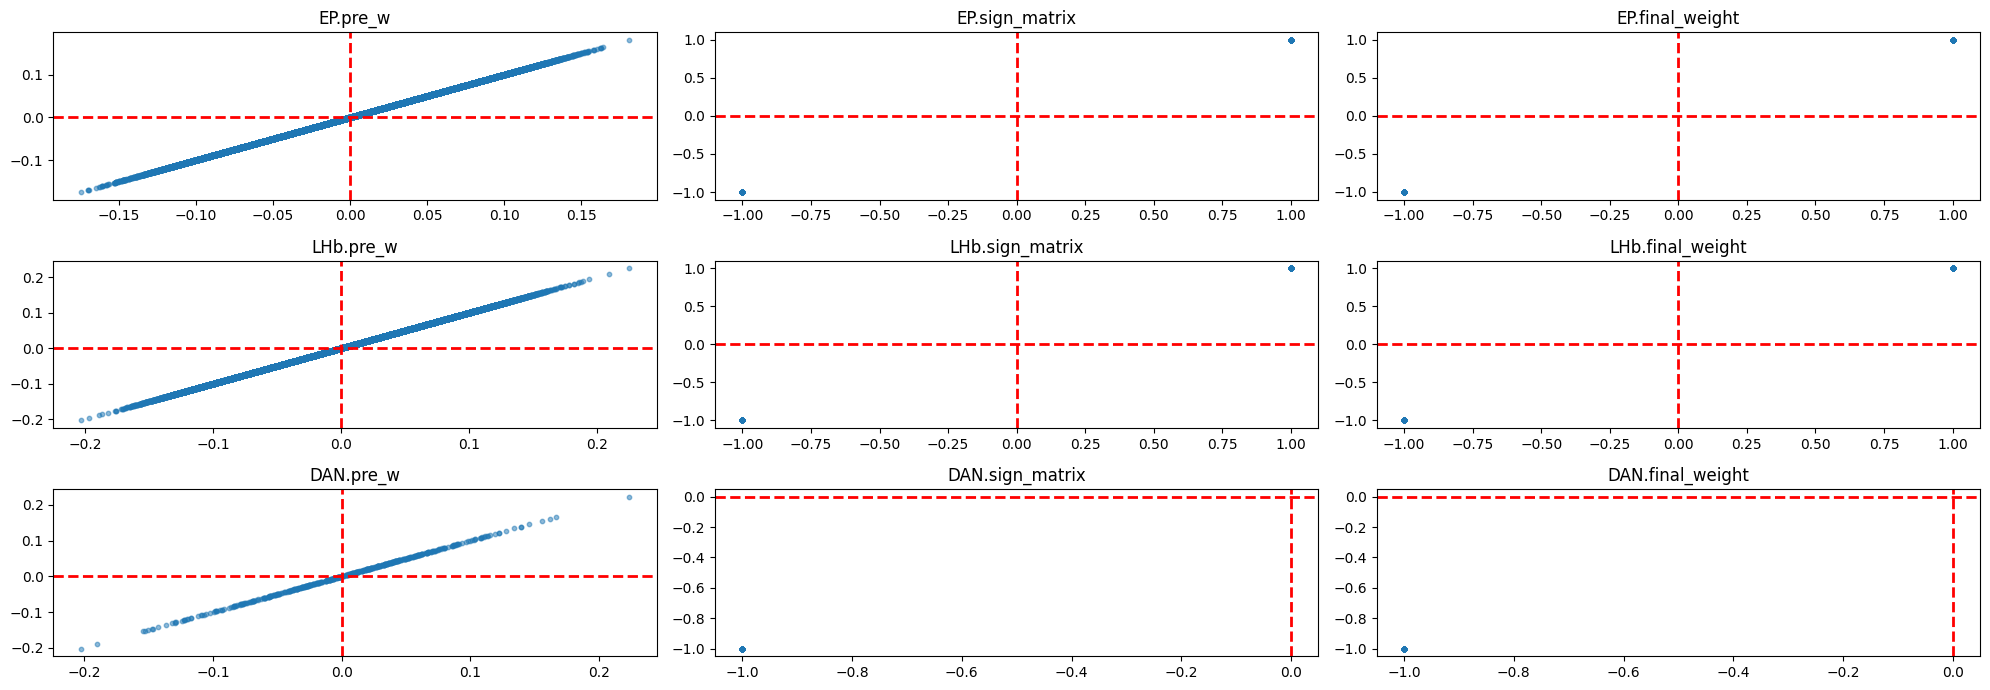

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
training MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons), reward-train, with opto neurons, loss:MSE
Epoch [1/5], Iteration: 0, Loss: 94718864.0000
Epoch [1/5], Iteration: 50, Loss: 95983856.0000
Epoch [1/5], Iteration: 100, Loss: 91625968.0000
Epoch [1/5], Iteration: 150, Loss: 90769064.0000
Epoch [2/5], Iteration: 0, Loss: 99989936.0000
Epoch [2/5], Iteration: 50, Loss: 108107248.0000
Epoch [2/5], Iteratio

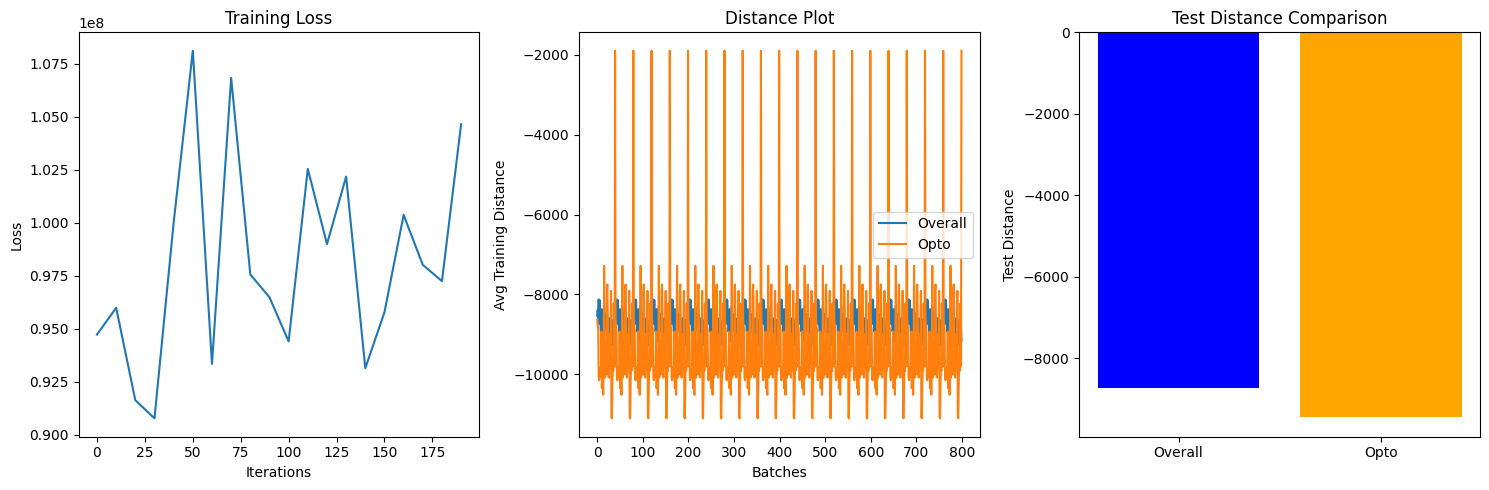

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
EP.pre_w flipped:  0.00% (0/401408)
EP.sign_matrix flipped:  0.00% (0/401408)
EP.final_weight flipped:  0.00% (0/401408)
LHb.pre_w flipped:  0.00% (0/262144)
LHb.sign_matrix flipped:  0.00% (0/262144)
LHb.final_weight flipped:  0.00% (0/262144)
DAN.pre_w flipped:  0.00% (0/512)
DAN.sign_matrix flipped:  0.00% (0/512)
DAN.final_weight flipped:  0.00% (0/512)
EP.pre_w changed:  0.00% (0/401408)
EP.sign_matrix changed:  0.00% (0/401

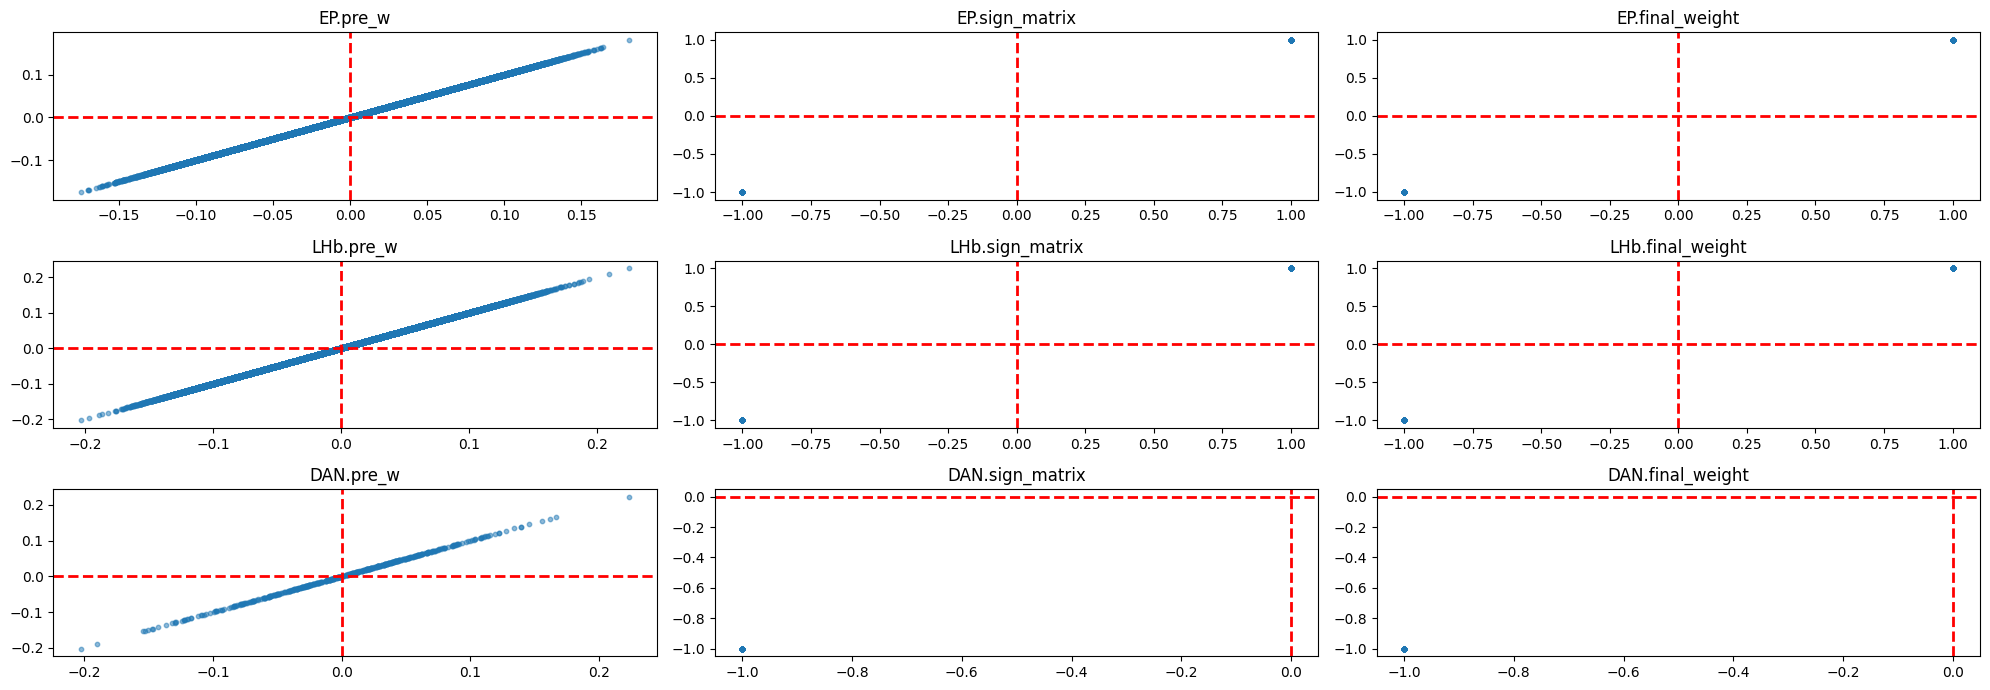

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
training MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons), punish-train, with opto neurons, loss:MSE
Epoch [1/5], Iteration: 0, Loss: 94717632.0000
Epoch [1/5], Iteration: 50, Loss: 95981896.0000
Epoch [1/5], Iteration: 100, Loss: 91624280.0000
Epoch [1/5], Iteration: 150, Loss: 90766320.0000
Epoch [2/5], Iteration: 0, Loss: 99987504.0000
Epoch [2/5], Iteration: 50, Loss: 108104624.0000
Epoch [2/5], Iteratio

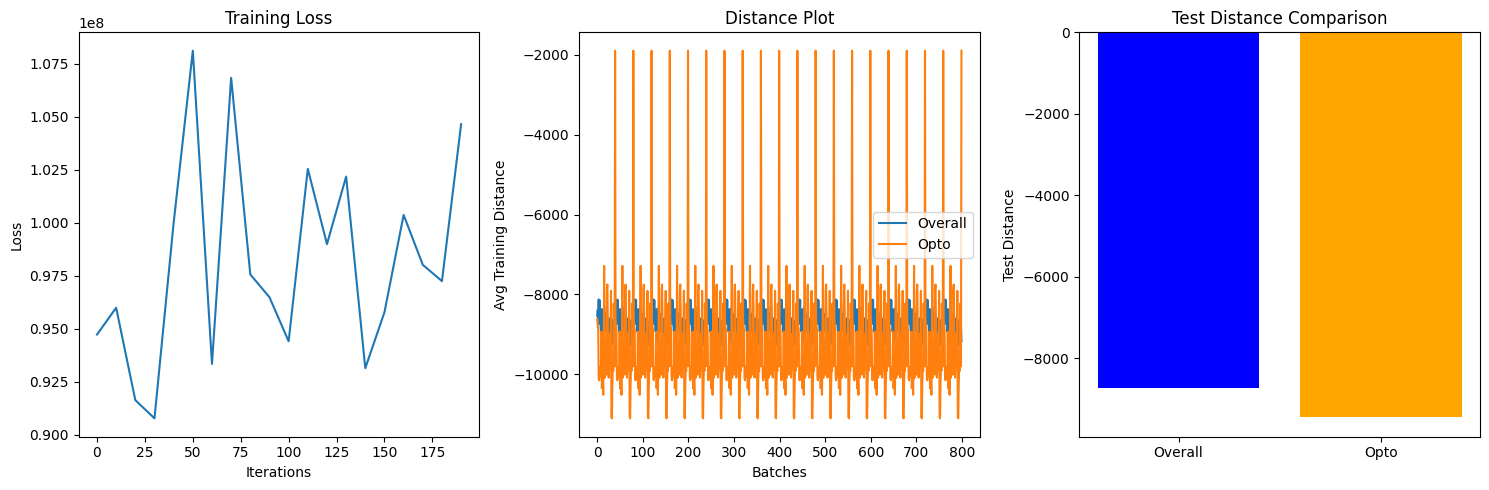

EP.pre_w: Positive: 49.90%; Negative: 50.10%; Zero: 0.00%
EP.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
EP.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.pre_w: Positive: 49.99%; Negative: 50.01%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
LHb.final_weight: Positive: 50.01%; Negative: 49.99%; Zero: 0.00%
DAN.pre_w: Positive: 52.54%; Negative: 47.46%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
EP.pre_w flipped:  0.00% (0/401408)
EP.sign_matrix flipped:  0.00% (0/401408)
EP.final_weight flipped:  0.00% (0/401408)
LHb.pre_w flipped:  0.00% (0/262144)
LHb.sign_matrix flipped:  0.00% (0/262144)
LHb.final_weight flipped:  0.00% (0/262144)
DAN.pre_w flipped:  0.00% (0/512)
DAN.sign_matrix flipped:  0.00% (0/512)
DAN.final_weight flipped:  0.00% (0/512)
EP.pre_w changed:  0.00% (0/401408)
EP.sign_matrix changed:  0.00% (0/401

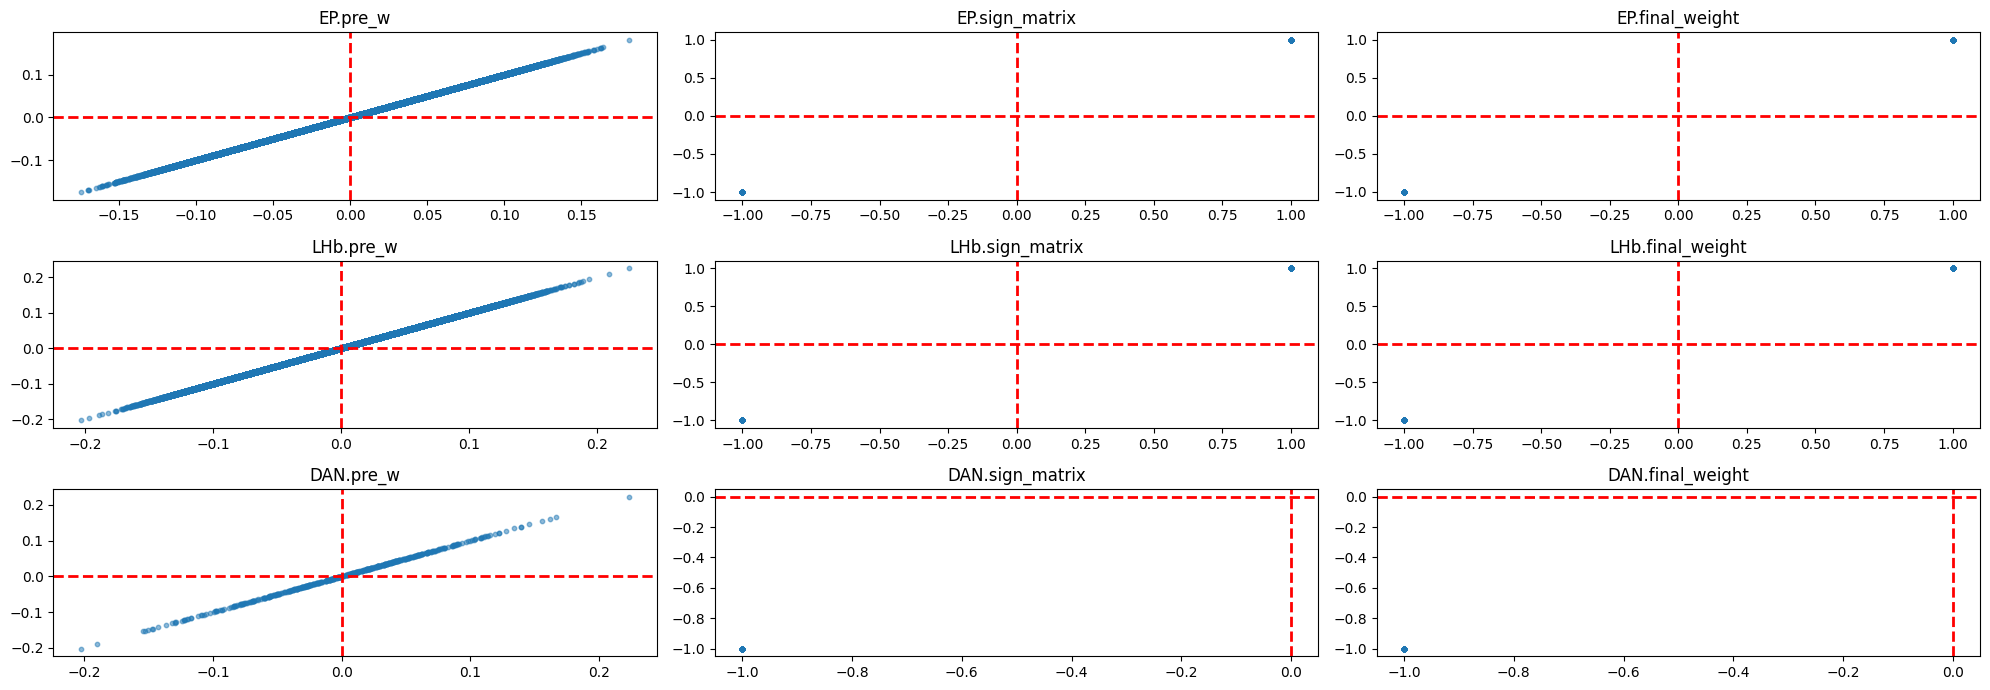

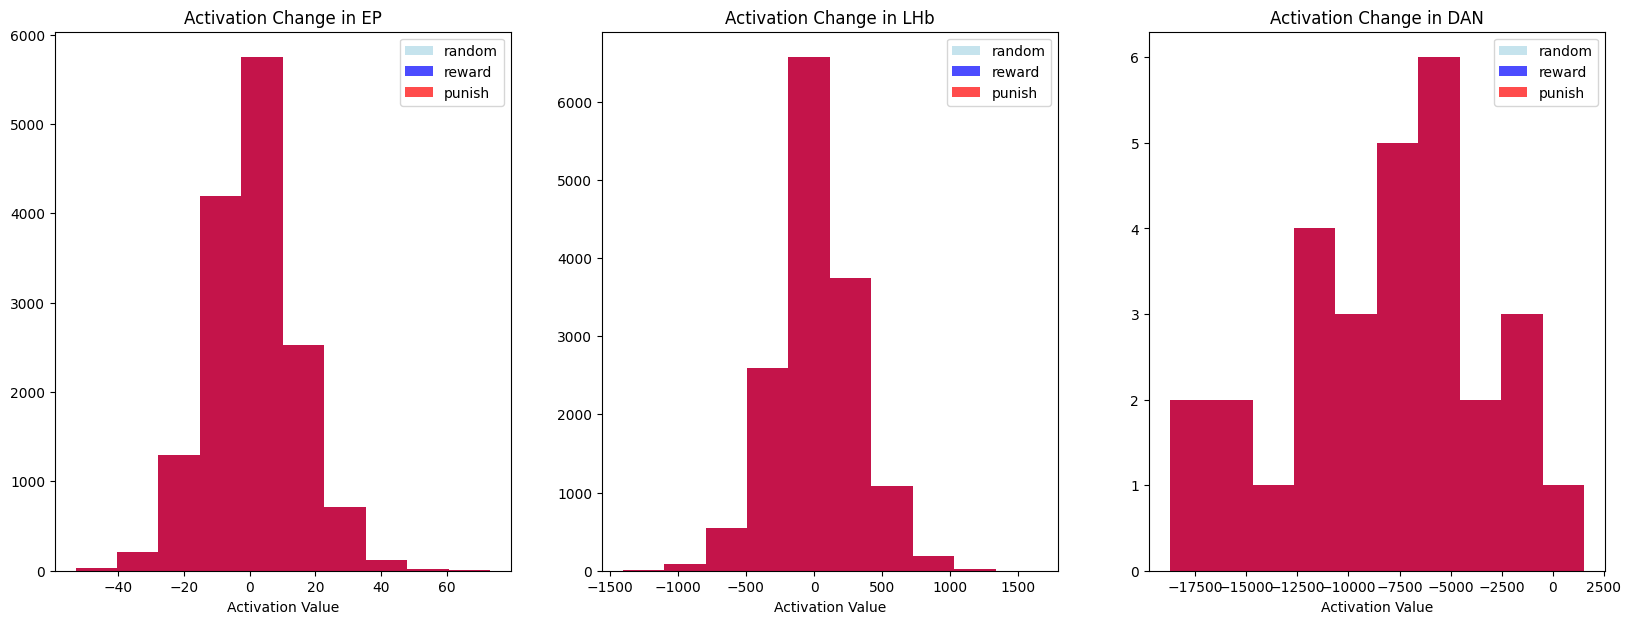

In [ ]:
# Training loop

for i in range(0, 1):
    for h1_count in range(len(h1_ls)):
        for h2_count in range(len(h2_ls)):
            for num in range(1,num_networks+1):
                # initialize results storage
                training_loss = []
                val_accuracy = []
                test_accuracy = []
                params_ls = []

                # network conditions
                network_type = network_dict["network_type"][i]

                # dales-law
                EP_LHb = network_dict["EP_LHb"][i]
                if EP_LHb == "dales-law":
                    dales_law = True
                else:
                    dales_law = False

                # Real LHb to DAN
                LHb_DAN = network_dict["LHb_DAN"][i]
                if LHb_DAN == "real":
                    real = True
                else:
                    real = False

                # Update method
                update_methods = network_dict["update_methods"][i]
                if update_methods == "fixed-sign":
                    fixed_sign = True
                else:
                    fixed_sign = False

                # split EI
                split_EI = network_dict["split_EI"][i]
                if split_EI == "combine_EI":
                    combine_EI = True
                elif split_EI == "split_EP_only":
                    split_EP_only = True
                else:
                    combine_EI = False

                
                
                
                # Instantiate model
                torch.manual_seed(1000)
                if split_EI == "split_EP_LHb":
                    model = Dales_Law_Model(in_features=in_features, h1=h1_ls[h1_count], h2=h2_ls[h2_count], 
                                            out_features=out_features).to(device)
                elif split_EI == "split_EP_only":
                    model = Dales_Law_Combine_LHb_Model(in_features=in_features, h1=h1_ls[h1_count], 
                                                        h2=h2_ls[h2_count], out_features=out_features).to(device)
                else:
                    model = Corelease_Model(in_features=in_features, h1=h1_ls[h1_count], h2=h2_ls[h2_count], 
                                            out_features=out_features, real = real, combine_EI = combine_EI, 
                                            opto_neuron_percent = opto_neuron_percent, batch_size = batch_size 
                                            ).to(device)

                # network name
                network_name = network_type+'_'+EP_LHb+'_'+LHb_DAN+'_'+update_methods+'_' + split_EI + '_' + str(num) + ' ('+ str(h1_ls[h1_count])+' EP neurons, ' + str(h2_ls[h2_count])+' LHb neurons)'
                # adam optimizer
                optimizer = optim.Adam(params = model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
                # Learning rate scheduler
                scheduler = CosineAnnealingLR(optimizer, T_max) 
                
                
                # record initial params
                initial_params = model.record_params()
                params_ls.append(initial_params.copy())
                initial_params_summary[network_name] = [initial_params.copy()]
                
                # Part 1: Random
                # random train model w/ opto activation
                if random_learning:
                    train_type = "random"
                    opto_on = False
                    criterion = nn.CrossEntropyLoss()
                    loss_function = "MSE"
                    print(f'training {network_name}, random-train, with opto, loss:{loss_function}')
                    train_model(model, random_train_loader, random_test_loader, random_val_loader, epochs, params_ls, opto_category, 
                                opto_on, loss_function)
                    
                    # record and store trained params
                    trained_params = model.record_params()
                    trained_params_summary[network_name] = [trained_params.copy()]
                    weight_changes(initial_params, trained_params)

                    # store random activations
                    random_activations = get_activations(model,random_opto_loader)
                    # plot_layer_activation([random_activations], plot = [True])
                    


                # Before reward/punish training, freeze all layers except LHb
                params_to_optimize = [model.LHb.pre_w]
                # update adam optimizer
                optimizer = optim.Adam(params = params_to_optimize, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
                
                
                # Part 2: Reward
                if reward_learning:
                    # record initial params
                    initial_params = model.record_params() 
                    initial_params_summary[network_name].append(initial_params.copy())
                    
                    # reward-train model w/ opto activation and MSE loss
                    train_type = "reward"
                    opto_on = True
                    model.opto_on = opto_on
                    criterion = nn.MSELoss()
                    loss_function = "MSE"
                    print(f'training {network_name}, reward-train, with opto neurons, loss:{loss_function}')
                    train_model(model, reward_train_loader, reward_test_loader, reward_val_loader, epochs, params_ls, opto_category, 
                                opto_on, loss_function)
                    
                    # record and store trained params
                    trained_params = model.record_params()
                    trained_params_summary[network_name].append(trained_params.copy())
                    weight_changes(initial_params, trained_params)
                    
                    # store reward activations
                    reward_activations = get_activations(model,reward_opto_loader)
                
                
                # Part 3: punish
                if punish_learning:
                    # record initial params
                    initial_params = model.record_params()
                    initial_params_summary[network_name].append(initial_params.copy())
                    
                    # punish-train model w/ opto activation and MSE loss
                    train_type = "punish"
                    opto_on = True
                    model.opto_on = opto_on
                    criterion = nn.MSELoss()
                    loss_function = "MSE"
                    print(f'training {network_name}, punish-train, with opto neurons, loss:{loss_function}')
                    train_model(model, punish_train_loader, punish_test_loader, punish_val_loader, epochs, params_ls, opto_category, 
                                opto_on, loss_function)
                    
                    # record and store trained params
                    trained_params = model.record_params()
                    trained_params_summary[network_name].append(trained_params.copy())
                    weight_changes(initial_params, trained_params)
                    
                    # store punish activations
                    punish_activations = get_activations(model,punish_opto_loader)
                
                # add to results dictionary - training_loss_summary, test_accuracy_summary
                params_summary[network_name] = params_ls
                training_loss_summary[network_name] = training_loss
                test_accuracy_summary[network_name] = test_accuracy
                val_accuracy_summary[network_name] = val_accuracy


# Plot activation values
activations = []
if random_learning: activations.append(random_activations)
if reward_learning: activations.append(reward_activations)
if punish_learning: activations.append(punish_activations)

plot_layer_activation(activations,plot=[random_learning,reward_learning,punish_learning])

In [ ]:
# get EP activations and opto indices
EP_activations_ls = model.EP_activations_ls
opto_idx_trainset = model.opto_idx_trainset

# get initial and trained params for random, reward, punish
random_idx = 0
reward_idx = 1
if reward_learning: punish_idx = 2
else: punish_idx = 1

random_train_initial_params = initial_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][random_idx]
random_train_trained_params = trained_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][random_idx]

if reward_learning:
    reward_train_initial_params = initial_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][reward_idx]
    reward_train_trained_params = trained_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][reward_idx]

if punish_learning:
    punish_train_initial_params = initial_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][punish_idx]
    punish_train_trained_params = trained_params_summary['MLP_random_real_corelease_no_split_1 (512 EP neurons, 512 LHb neurons)'][punish_idx]

In [ ]:
# Package into pickle file
packed = {"EP_activations_ls": model.EP_activations_ls, "opto_idx_trainset": model.opto_idx_trainset}

packed["random_train_initial_params"] = random_train_initial_params
packed["random_train_trained_params"] = random_train_trained_params
train_name = "random"

if reward_learning:
    packed["reward_train_initial_params"] = reward_train_initial_params
    packed["reward_train_trained_params"] = reward_train_trained_params
    train_name += "-reward"

if punish_learning:
    packed["punish_train_initial_params"] = punish_train_initial_params
    packed["punish_train_trained_params"] = punish_train_trained_params
    train_name += "-punish"

# Save the list as a pickle file
print(f'Saving weights to FMNIST_weights_{train_name}.pkl')
with open(f'FMNIST_weights_{train_name}.pkl', 'wb') as f:
    pickle.dump(packed, f)

## Model analysis

In [ ]:
# # Unpack pickle files
# train_name = "random-reward-punish"

# with open(f'FMNIST_weights_{train_name}.pkl', 'rb') as f:
#     FMNIST_weight = pickle.load(f)

# # Get EP activations and opto indices
# EP_activations_ls = FMNIST_weight['EP_activations_ls']
# opto_idx_trainset = FMNIST_weight['opto_idx_trainset']

# # Get initial and trained params
# random_learning = "random" in train_name
# reward_learning = "reward" in train_name
# punish_learning = "punish" in train_name

# if random_learning:
#     random_train_initial_params = FMNIST_weight['random_train_initial_params']
#     random_train_trained_params = FMNIST_weight['random_train_trained_params']

# if reward_learning:
#     reward_train_initial_params = FMNIST_weight['reward_train_initial_params']
#     reward_train_trained_params = FMNIST_weight['reward_train_trained_params']
    
# if punish_learning:
#     punish_train_initial_params = FMNIST_weight['punish_train_initial_params']
#     punish_train_trained_params = FMNIST_weight['punish_train_trained_params']

In [ ]:
LHb_weight = list(random_train_initial_params)[4]
opto_neurons = choose_neuron(EP_activations_ls, opto_idx_trainset, 0.05, largest = True)
lowest_neurons = choose_neuron(EP_activations_ls, opto_idx_trainset, 0.05, largest = False)

# Decide what to plot
plot_random = random_learning
plot_reward = reward_learning
plot_punish = punish_learning

In [ ]:
# Step 1: Create a tensor with values from 1 to 512
all_values = torch.arange(0, 512)
non_opto_neurons = all_values[~torch.isin(all_values, torch.tensor(opto_neurons))]

# Preallocate the top and bottom activation value lists
# Calculate expected sizes if possible
num_batches = len(EP_activations_ls)
num_opto_neurons = len(opto_neurons)  # Assuming this is known
num_lowest_neurons = len(lowest_neurons)

top_act_vals = []
bottom_act_vals = []

for batch_idx in range(num_batches):
    # Get the category indices for the current batch
    category_indices = opto_idx_trainset[batch_idx]
    
    # Gather all opto tensors for the top activations in one go
    top_opto_tensors = EP_activations_ls[batch_idx][category_indices][:, opto_neurons]

    # Append to top_act_vals
    top_act_vals.extend(top_opto_tensors.flatten().tolist())

    # Gather bottom activations in one go using filtered values
    bottom_opto_tensors = EP_activations_ls[batch_idx][category_indices][:, lowest_neurons]

    # Append to bottom_act_vals
    bottom_act_vals.extend(bottom_opto_tensors.flatten().tolist())

# Convert lists to tensors if needed
top_act_vals = torch.tensor(top_act_vals)
bottom_act_vals = torch.tensor(bottom_act_vals)

top_act_vals = top_act_vals[::4]
bottom_act_vals = bottom_act_vals[::50]

# Plot a bar chart
fig, ax = plt.subplots(figsize=(6, 5))
scatterboxplot([top_act_vals, bottom_act_vals], ["Top Activation Values", "Bottom Activation Values"], ax)
ax.set_title(f"Average Activation Values during Opto Category: {opto_category}")
ax.set_ylabel("Average Activation Value")

In [ ]:
# Calculate total positive and negative weight for each neuron
def calculate_weights(weight_matrix, pre_neurons):
    '''
    Weight matrix is of size n_post x n_pre. Therefore, each row represents the weights of a single post-synaptic neuron
    Thus this function returns the total positive and negative weights coming from pre_neurons for each postsynaptic neuron
    '''
    selected_weights = weight_matrix[:, pre_neurons]
    positive_weights = torch.sum(selected_weights * (selected_weights > 0), dim=1)
    negative_weights = torch.sum(selected_weights * (selected_weights < 0), dim=1)
    
    return positive_weights.numpy(), negative_weights.numpy()

def calculate_EIindex(weight_matrix, pre_neurons):
    '''
    Weight matrix is of size n_post x n_pre. Therefore, each row represents the weights of a single post-synaptic neuron
    Thus this function returns the EI index calculated from the weights coming from pre_neurons for each postsynaptic neuron
    '''
    selected_weights = weight_matrix[:, pre_neurons]
    positive_weights = torch.sum(selected_weights * (selected_weights > 0), dim=1)
    negative_weights = -torch.sum(selected_weights * (selected_weights < 0), dim=1)
    
    return ((negative_weights-positive_weights) / (positive_weights + negative_weights)).numpy()

# Calculate weight differences for each synapse in LHb
key = 'LHb.final_weight'
# top 5% activated neurons
# random train
random_train_trained_exci_top, random_train_trained_inhi_top = calculate_weights(random_train_trained_params[key], opto_neurons)
random_train_trained_EIindex_top = calculate_EIindex(random_train_trained_params[key], opto_neurons)

# Caluclate weight differences for each synapse in LHb
random_weight_diff_top = (random_train_trained_params[key][:, opto_neurons] - random_train_initial_params[key][:, opto_neurons]).numpy()

# bottom 5% activated neurons
# random train
random_train_trained_exci_bot, random_train_trained_inhi_bot = calculate_weights(random_train_trained_params[key], lowest_neurons)
random_train_trained_EIindex_bot = calculate_EIindex(random_train_trained_params[key], lowest_neurons)

# Caluclate weight differences for each synapse in LHb
random_weight_diff_bot = (random_train_trained_params[key][:, lowest_neurons] - random_train_initial_params[key][:, lowest_neurons]).numpy()

# all neurons
# random train
random_train_trained_exci_all, random_train_trained_inhi_all = calculate_weights(random_train_trained_params[key], torch.arange(random_train_trained_params[key].shape[1]))
random_train_trained_EIindex_all = calculate_EIindex(random_train_trained_params[key], torch.arange(random_train_trained_params[key].shape[1]))

# Calculate weight differences for each synapse in LHb
random_weight_diff_all = (random_train_trained_params[key] - random_train_initial_params[key]).numpy()


if reward_learning:
    # reward train top 5% activated neurons
    reward_train_trained_exci_top, reward_train_trained_inhi_top = calculate_weights(reward_train_trained_params[key], opto_neurons)
    reward_train_trained_EIindex_top = calculate_EIindex(reward_train_trained_params[key], opto_neurons)
    
    # Caluclate weight differences for each synapse in LHb
    reward_weight_diff_top = (reward_train_trained_params[key][:, opto_neurons] - reward_train_initial_params[key][:, opto_neurons]).numpy()

    # bottom 5% activated neuron
    # reward train
    reward_train_trained_exci_bot, reward_train_trained_inhi_bot = calculate_weights(reward_train_trained_params[key], lowest_neurons)
    reward_train_trained_EIindex_bot = calculate_EIindex(reward_train_trained_params[key], lowest_neurons)

    # Caluclate weight differences for each synapse in LHb
    reward_weight_diff_bot = (reward_train_trained_params[key][:, lowest_neurons] - reward_train_initial_params[key][:, lowest_neurons]).numpy()
    
    # all neurons
    # reward train
    reward_train_trained_exci_all, reward_train_trained_inhi_all = calculate_weights(reward_train_trained_params[key], torch.arange(reward_train_trained_params[key].shape[1]))
    reward_train_trained_EIindex_all = calculate_EIindex(reward_train_trained_params[key], torch.arange(reward_train_trained_params[key].shape[1]))
    
    # Calculate weight differences for each synapse in LHb
    reward_weight_diff_all = (reward_train_trained_params[key] - reward_train_initial_params[key]).numpy()

if punish_learning:   
    # punish train top 5% activated neurons
    punish_train_trained_exci_top, punish_train_trained_inhi_top = calculate_weights(punish_train_trained_params[key], opto_neurons)
    punish_train_trained_EIindex_top = calculate_EIindex(punish_train_trained_params[key], opto_neurons)

    # Caluclate weight differences for each synapse in LHb
    punish_weight_diff_top = (punish_train_trained_params[key][:, opto_neurons] - punish_train_initial_params[key][:, opto_neurons]).numpy()

    # bottom 5% activated neuron
    # punish train
    punish_train_trained_exci_bot, punish_train_trained_inhi_bot = calculate_weights(punish_train_trained_params[key], lowest_neurons)
    punish_train_trained_EIindex_bot = calculate_EIindex(punish_train_trained_params[key], lowest_neurons)

    # Caluclate weight differences for each synapse in LHb
    punish_weight_diff_bot = (punish_train_trained_params[key][:, lowest_neurons] - punish_train_initial_params[key][:, lowest_neurons]).numpy()

    # all neurons
    # punish train
    punish_train_trained_exci_all, punish_train_trained_inhi_all = calculate_weights(punish_train_trained_params[key], torch.arange(punish_train_trained_params[key].shape[1]))
    punish_train_trained_EIindex_all = calculate_EIindex(punish_train_trained_params[key], torch.arange(punish_train_trained_params[key].shape[1]))

    # Calculate weight differences for each synapse in LHb
    punish_weight_diff_all = (punish_train_trained_params[key] - punish_train_initial_params[key]).numpy()

In [ ]:
# Create subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=False, sharey=False)

# Top 5% activated neurons
if plot_random: axs[0].scatter(random_train_trained_exci_top, -random_train_trained_inhi_top, label="Random", color="lightblue")
if plot_reward: axs[0].scatter(reward_train_trained_exci_top, -reward_train_trained_inhi_top, label="Reward", color="blue")
if plot_punish: axs[0].scatter(punish_train_trained_exci_top, -punish_train_trained_inhi_top, label="Punish", color="red")
axs[0].set_title("Excitatory vs Inhibitory (top 5% activated neurons - 'opto neurons')")
axs[0].legend()
axs[0].set_xlabel("Total excitatory weights")
axs[0].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[0].get_xlim()[0], axs[0].get_ylim()[0]), max(axs[0].get_xlim()[1], axs[0].get_ylim()[1]), 100)
axs[0].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# Bottom 5% activated neurons
if plot_random: axs[1].scatter(random_train_trained_exci_bot, -random_train_trained_inhi_bot, label="Random", color="lightblue")
if plot_reward: axs[1].scatter(reward_train_trained_exci_top, -reward_train_trained_inhi_top, label="Reward", color="blue")
if plot_punish: axs[1].scatter(punish_train_trained_exci_bot, -punish_train_trained_inhi_bot, label="Punish", color="red")
axs[1].set_title("Excitatory vs Inhibitory (bottom 5% activated neurons)")
axs[1].legend()
axs[1].set_xlabel("Total excitatory weights")
axs[1].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[1].get_xlim()[0], axs[1].get_ylim()[0]), max(axs[1].get_xlim()[1], axs[1].get_ylim()[1]), 100)
axs[1].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# All neurons
if plot_random: axs[2].scatter(random_train_trained_exci_all, -random_train_trained_inhi_all, label="Random", color="lightblue")
if plot_reward: axs[2].scatter(reward_train_trained_exci_all, -reward_train_trained_inhi_all, label="Reward", color="blue")
if plot_punish: axs[2].scatter(punish_train_trained_exci_all, -punish_train_trained_inhi_all, label="Punish", color="red")
axs[2].set_title("Excitatory vs Inhibitory (all neurons)")
axs[2].legend()
axs[2].set_xlabel("Total excitatory weights")
axs[2].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[2].get_xlim()[0], axs[2].get_ylim()[0]), max(axs[2].get_xlim()[1], axs[2].get_ylim()[1]), 100)
axs[2].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# Adjust layout
plt.tight_layout()
#plt.savefig('Reward_weight_change_scatter.png', dpi=300)
plt.show()

In [ ]:
# Plot first 100 neurons' (opto tagged) weights in pre vs post
n_row = 6
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(30, 40))
plt.subplots_adjust(hspace=0.5)

for i, neuron in enumerate(opto_neurons[:n_row*n_col]):
    if plot_random: axs.flatten()[i].hist(random_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "random", color = "lightblue")
    if plot_reward: axs.flatten()[i].hist(reward_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "Reward", color = "blue")
    if plot_punish: axs.flatten()[i].hist(punish_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "Punish", color = "red")

    axs.flatten()[i].set_xlabel('Weights')
    axs.flatten()[i].set_title(f'%s (EP neuron %d)' %(LHb_weight, neuron))
    axs.flatten()[i].legend()
    
#plt.savefig('Reward_weight_change.png', dpi=300)

In [ ]:
n_row = 6
n_col = 4
fig, axs = plt.subplots(n_row, n_col, figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)

# Use a counter for subplot index
for subplot_idx, neuron in enumerate(opto_neurons[:n_row*n_col]):
    if plot_random: axs.flatten()[subplot_idx].hist(random_weight_diff_top[neuron], alpha=0.7, label="Reward", color="lightblue")
    if plot_reward: axs.flatten()[subplot_idx].hist(reward_weight_diff_top[neuron], alpha=0.7, label="Reward", color="blue")
    if plot_punish: axs.flatten()[subplot_idx].hist(punish_weight_diff_top[neuron], alpha=0.7, label="Punish", color="red")

    axs.flatten()[subplot_idx].set_xlabel('Weight change')
    axs.flatten()[subplot_idx].set_title(f'%s changes (neuron %d)' % (LHb_weight, neuron))
    axs.flatten()[subplot_idx].legend()

#plt.savefig('Reward_weight_diff_change.png', dpi=300)


In [ ]:
# Plot EI index distribution

# Decide what to plot
if plot_random: 
    data = [random_train_trained_EIindex_top]
    labels = ["Random"]
if reward_learning: 
    data.append(reward_train_trained_EIindex_top)
    labels.append("Reward")
if punish_learning: 
    data.append(punish_train_trained_EIindex_top)
    labels.append("Punish")

# Plot EI index distribution
fig, axs = plt.subplots(1, figsize=(10, 6))
scatterboxplot(data, labels, axs, vert=False)

# t_stat, p_value = stats.ttest_ind(random_train_trained_EIindex_top, punish_train_trained_EIindex_top)
# plt.text(max(max(random_train_trained_EIindex_top), max(punish_train_trained_EIindex_top)) + 0.1, 1.5, f'p = {p_value:.2e}', ha='center', fontsize=12)

axs.set_title('EI index')
axs.set_xlabel('EI index')
axs.set_xlim(-1.1, 1.1)

plt.show()
#plt.savefig('Reward_EI_Index.png', dpi=300)

In [ ]:
# Plot EI index distribution
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

random_data = random_train_trained_EIindex_top
punish_data = punish_train_trained_EIindex_top
axs[0].boxplot([random_data, punish_data], labels=["Random", "Punish"], vert=False)
for i in range(len(random_data)):
    axs[0].plot([random_data[i], punish_data[i]],[1, 2], alpha=0.24, color='gray')

axs[0].scatter(random_data, np.ones(len(random_data)) * 1 + np.random.normal(0, 0.02, len(random_data)), color="gray", label="Random", alpha=0.6)
axs[0].scatter(punish_data, np.ones(len(punish_data)) * 2 + np.random.normal(0, 0.02, len(punish_data)), color="blue", label="Punish", alpha=0.6)

t_stat, p_value = stats.ks_2samp(random_data, punish_data)
axs[0].text(max(max(punish_data), max(punish_data)) + 0.1, 1.5, f'p = {p_value:.2}', ha='center', fontsize=12)
axs[0].set_title('EI index')
axs[0].set_xlabel('EI index')
axs[0].set_xlim(-1, 1)


random_data = random_train_trained_EIindex_top[random_neurons[:,1]]
punish_data = punish_train_trained_EIindex_top[punish_neurons[:,1]]
axs[1].boxplot([random_data, punish_data], labels=["Random", "Punish"], vert=False)
for i in range(len(random_data)):
    axs[1].plot([random_data[i], punish_data[i]],[1, 2], alpha=0.24, color='gray')

axs[1].scatter(random_data, np.ones(len(random_data)) * 1 + np.random.normal(0, 0.02, len(random_data)), color="gray", label="Random", alpha=0.6)
axs[1].scatter(punish_data, np.ones(len(punish_data)) * 2 + np.random.normal(0, 0.02, len(punish_data)), color="blue", label="Punish", alpha=0.6)

t_stat, p_value = stats.ks_2samp(random_data, punish_data)
axs[1].text(max(max(random_data), max(punish_data)) + 0.1, 1.5, f'p = {p_value:.2}', ha='center', fontsize=12)
axs[1].set_title('EI index')
axs[1].set_xlabel('EI index')
axs[1].set_xlim(-1, 1)
"""


# Summary of all simulations
p_vals = []
for sim in range(nboot):
    random_data = pre_train_trained_EIindex[random_neurons[:,sim]]
    reward_data = post_train_trained_EIindex[reward_neurons[:,sim]]
    t_stat, p_value = stats.ks_2samp(random_data, reward_data)
    p_vals.append(p_value)
axs[2].boxplot(p_vals, vert=False)
axs[2].scatter(p_vals, np.ones(len(p_vals)) * 1 + np.random.normal(0, 0.02, len(p_vals)), color="blue", alpha=0.6)
axs[2].axvline(x=0.05, color='red', linestyle=':', linewidth=2)
axs[2].set_xlabel('Simulated p-value')
"""

## Other useful code

In [ ]:
gradient_mean_means = []

for key in model.gradient_history.keys():
    gradient_means = []
    for i in model.gradient_history[key]:
        mean = torch.mean(i)
        gradient_means.append(mean)
    gradient_mean_means.append(gradient_means)    
    plt.plot(gradient_means, alpha = 0.2)
df = pd.DataFrame(gradient_mean_means)
#mean for each row
plt.plot(df.mean().tolist())
plt.title("Gradient Change During Reward Training for Opto Neurons (Highest Activation)", y = 1.05)

#plt.savefig("GradientChangeReward.png", dpi = 300)